# Lab 1
👨‍🎓 Students:
- Nikita Kiselov
- Marwan Mashra

## Imports

In [74]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math

## Read files

In [75]:
file_paths = ["string_1.wav", "string_2.wav", "string_3.wav"]

# read wav file into the dictionary
wav_dict = {}
for file_path in file_paths:
    rate, data = wav.read("audio/"+file_path)
    wav_dict[file_path] = [rate, data]

## Setup notes

In [76]:
# set of notes frequencies in Hz
E1 =  329.63 
B2 = 246.94 
G3 = 196.00 
D4 = 146.83 
A5 = 110.00 
E6 = 82.41 

# find the note 
notes = {E1: "E1", B2: "B2", G3: "G3", D4: "D4", A5: "A5", E6: "E6"}

## Processing the recording

In [77]:
# picking the recording file 
file = "string_2.wav"
rate, data = wav_dict[file]

rate is the average number of samples obtained in one second, and data contains the amplitude of each sample.

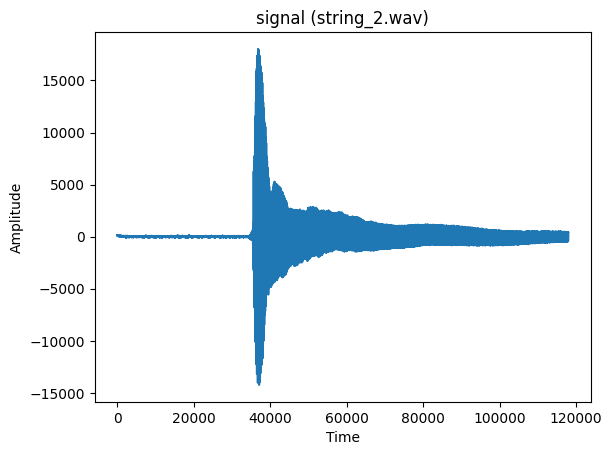

In [78]:
# plot the signal
plt.plot(data)
plt.title(f"signal ({file})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [79]:
# normalize the signal to -1 and 1 
data = data - np.mean(data)
data = data / np.max(np.abs(data))

Normalizing a signal is bringing it to a predefined range (here [-1, 1]). Although this step is not mandatory for applying the Fourier Transform and finding the notes, it does help for the visualization, analysis, and when comparing multiple signals.

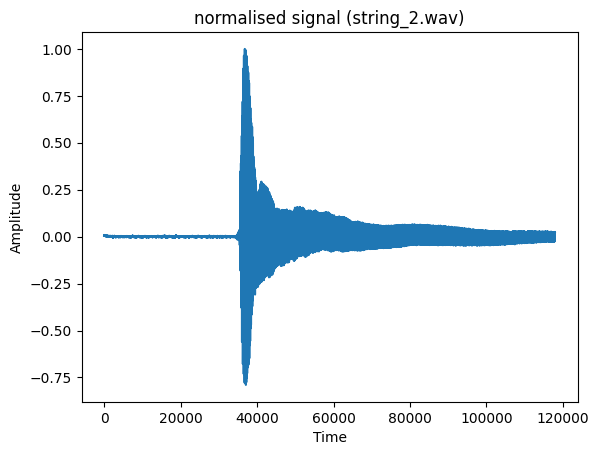

In [80]:
# plot the normalised signal
plt.plot(data)
plt.title(f"normalised signal ({file})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#### FFT computation

FFT or fast Fourier transform is an opitmized and efficient algorithem used to compute the DFT (discrete Fourier Transform) of a signal. It's the most commun implementation of the DFT.

In [81]:
fft_out = np.fft.fft(data)

#### Frequency bins

Now, we want to plot the frequency spectrum of the discrete Fourier Transform. However, since the frequency is continous, we first need to discretize it (transform continuous frequencies into discerte points or **bins**).  The number of **frequency bins** depends on the number of points in the DFT and the sampling rate. The $n^{th}$ frequency bin can be obtained as following :
$$
n^{th}bin = n*\dfrac{rate}{len(DFT)}
$$
We use the function fftfreq provided by NumPy to get sample frequencies

In [82]:
frequencies = np.fft.fftfreq(len(fft_out), 1/rate)

We then only plot the right side of the frequency spectrum by taking the absolute values of both the frequency bins and the DFT (since we now they're mirrored around 0)

In [83]:
frequencies = np.abs(frequencies)
fft_out = np.abs(fft_out)

Finally, we can plot the frequency spectrum with x-axis being the frequency, and y-axis being the power (or magnitude) of each frequency in the signal.

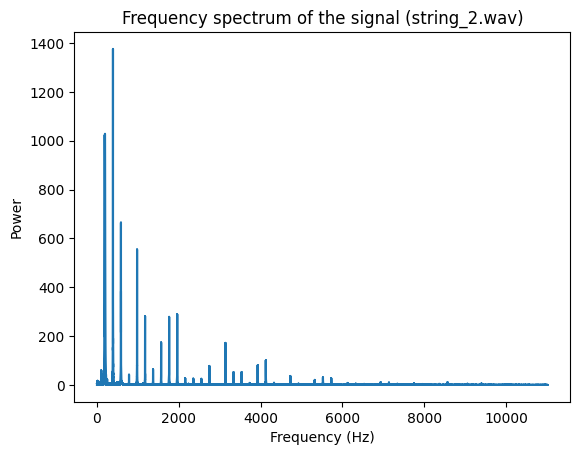

In [84]:
plt.plot(frequencies, fft_out)
plt.title(f"Frequency spectrum of the signal ({file})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

We notice several peaks, with the biggest ones being between 200, and 1000. To better observe those peaks, we can plot the frequencies with Plotly which produces an interactive plot allowing us to zoom in and out

In [72]:
# plot frequencies with plotly
import plotly.express as px
i = frequencies < 1000
fig = px.line(x=frequencies[i], y=fft_out[i])
fig.show()

We see that the peak frequency is around 400. To find the exact peak frequency we can use the argmax:

In [73]:
peak_freq = frequencies[np.argmax(fft_out)]
print(peak_freq)

392.14710970893543


#### Note detection

Now we define the function to detect the note. Our Algorithm consists of 3 steps:

1) Detecting the highest peak in the frequency and use it to find the note with closest value of frequency.

2) **Evaluate difference in cents**

For this we use the original formula but in the reverse form:
$$
cents = |(\log_2(note_{gold} / note_{detected}))*1200|
$$

3) **Check the overtone**

Now we assume that detected peak can be the overtone of the note. Overtone occurs because of the physical properties of the guitar string and their frequency usually bigger on ~2x,3x,4x, etc..


<img src="image-20220923-094423.png" width="350"/>

if the difference between "gold" note and our detected is >200 cents (1/6 of the octave), we assume that we detected the overtone of the original played note.

Now we recursively divide the detected freq. peak by coeficinets and checking if it corresponds to the gold note.

In [92]:
def find_note(peak_freq, depth=1):
    
    # find the note closest to the peak frequency
    closest_note = min(notes.keys(), key=lambda x:abs(x-peak_freq))
    
    # cents diff 
    cents = round(abs(math.log(closest_note/peak_freq, 2) * 1200),2)
    
    if cents > 200: # 1/6 of octave
        print("Difference is {} cents. Assuming the overtone detected".format(cents))
        if depth > 4:
            return "No note detected"
        return find_note(peak_freq/(depth+1), depth+1)
    else:
        print("The note is {} with accuracy of {} cents".format(notes[closest_note], cents))

In [93]:
find_note(peak_freq)

Difference is 300.66 cents. Assuming the overtone detected
The note is G3 with accuracy of 0.65 cents


## Processing all recordings
We define the same detection function, but now end-to-end for the file:

In [109]:
def find_note_from_file(file_path):

    rate, data = wav_dict[file_path]

    data = data - np.mean(data)
    data = data / np.max(np.abs(data))

    fft_out = np.fft.fft(data)

    frequencies = np.fft.fftfreq(len(fft_out), 1/rate)

    frequencies = np.abs(frequencies)
    fft_out = np.abs(fft_out)

    peak_freq = frequencies[np.argmax(fft_out)]

    print(f"Audio File: {file_path}")
    find_note(peak_freq)
    print("-------------------------------------------------")

In [110]:
for file_path in file_paths:
    find_note_from_file(file_path)

Audio File: string_1.wav
The note is E1 with accuracy of 0.27 cents
-------------------------------------------------
Audio File: string_2.wav
Difference is 300.66 cents. Assuming the overtone detected
The note is G3 with accuracy of 0.65 cents
-------------------------------------------------
Audio File: string_3.wav
The note is A5 with accuracy of 1.92 cents
-------------------------------------------------


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3b92155e-6336-4deb-b620-c6db9f6644a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>